#### 여러 딕셔너리 테이블 하나로

In [1]:
# 필요 패키지 불러오기
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime as dt

In [2]:
def date_format(d):
    d = str(d).replace('-','.') # 날짜 구분자가 '-'로 되어있을 때 '.'으로 변환
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    
    this_date = dt.date(yyyy, mm, dd)
    return this_date

In [3]:
def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()
    return (this_date)

In [4]:
# 함수정의
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   
        start_date = date_format(start_date)   
    else:    
        start_date = dt.date.today() 
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = \
    'http://finance.naver.com/sise/sise_index_day.nhn?code=' \
    + index_cd + '&page=' + str(page_n)
    
    # 지정한 페이지에서 코드 읽기
    source = urlopen(naver_index).read()
    # 뷰티풀 스프로 태그별로 코드 분류
    source = BeautifulSoup(source, 'lxml')   
    
    # <td class="date">태그에서 날짜 수집   
    dates = source.find_all('td', class_='date')  
    # <td class="number_1">태그에서 지수 수집
    prices = source.find_all('td', class_='number_1')  
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # 0,4,8...
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page) 
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [5]:
def index_global(d, symbol, start_date='', end_date='', page=1):

    end_date = date_format(end_date)
    if start_date == '':
        start_date = end_date - pd.DateOffset(months=1)
    start_date = date_format(start_date)
        
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' \
    + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    if len(data) > 0:
        
        for n in range(len(data)):
            date = pd.to_datetime(data[n]['xymd']).date()

            if date <= end_date and date >= start_date:   
                
                price = float(data[n]['clos'])
                d[date] = price
                
            elif date < start_date:   
                
                return (d)              

        if len(data) == 10:
            
            page += 1
            index_global(d, symbol, start_date, end_date, page)
        
    return (d)

In [6]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, '2020-1-1','2020-12-15')

In [7]:
index_cd = 'SPI@SPX'
historical_prices = dict()
sp500 = index_global(historical_prices, index_cd, '2020-1-1','2020-12-15')

In [8]:
tmp = {'KOSPI200': kospi200,'S&P500': sp500}
tmp

{'KOSPI200': {datetime.date(2020, 12, 15): 370.88,
  datetime.date(2020, 12, 14): 371.56,
  datetime.date(2020, 12, 11): 372.24,
  datetime.date(2020, 12, 10): 369.37,
  datetime.date(2020, 12, 9): 371.47,
  datetime.date(2020, 12, 8): 363.45,
  datetime.date(2020, 12, 7): 369.86,
  datetime.date(2020, 12, 4): 367.63,
  datetime.date(2020, 12, 3): 361.66,
  datetime.date(2020, 12, 2): 358.66,
  datetime.date(2020, 12, 1): 352.4,
  datetime.date(2020, 11, 30): 346.05,
  datetime.date(2020, 11, 27): 352.73,
  datetime.date(2020, 11, 26): 352.12,
  datetime.date(2020, 11, 25): 348.3,
  datetime.date(2020, 11, 24): 350.28,
  datetime.date(2020, 11, 23): 348.46,
  datetime.date(2020, 11, 20): 340.62,
  datetime.date(2020, 11, 19): 340.16,
  datetime.date(2020, 11, 18): 339.96,
  datetime.date(2020, 11, 17): 339.85,
  datetime.date(2020, 11, 16): 340.63,
  datetime.date(2020, 11, 13): 333.03,
  datetime.date(2020, 11, 12): 329.72,
  datetime.date(2020, 11, 11): 331.12,
  datetime.date(2020, 

In [9]:
# 데이터프레임화
df = pd.DataFrame(tmp)
df_sort = df.sort_index(ascending=False) # 날짜순으로 정렬
df_sort

,KOSPI200,S&P500
2020-12-15,370.88,3694.62
2020-12-14,371.56,3647.49
2020-12-11,372.24,3663.46
2020-12-10,369.37,3668.10
2020-12-09,371.47,3672.82
...,...,...
2020-01-08,289.42,3253.05
2020-01-07,291.23,3237.18
2020-01-06,288.43,3246.28
2020-01-03,290.74,3234.85


In [10]:
# 보간이 필요
# fillna(method='ffill') 또는 fillna(method='bfill')
# ffill => forward fill (앞의 데이터로 뒤를 채움)
# bfill => backward fill (뒤의 데이터로 앞을 채움)
# 날짜 정렬에 따라 다르게 적용해야 함
df_sort = df_sort.fillna(method='bfill')
if df_sort.isnull().values.any():
    df_sort = df_sort.fillna(method='ffill')
df_sort

,KOSPI200,S&P500
2020-12-15,370.88,3694.62
2020-12-14,371.56,3647.49
2020-12-11,372.24,3663.46
2020-12-10,369.37,3668.10
2020-12-09,371.47,3672.82
...,...,...
2020-01-08,289.42,3253.05
2020-01-07,291.23,3237.18
2020-01-06,288.43,3246.28
2020-01-03,290.74,3234.85


----

In [11]:
#### 2007~2020 데이터 모으기
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, '2007-1-1', '2020-12-15')

In [12]:
index_cd = 'SPI@SPX'
historical_prices = dict()
sp500 = index_global(historical_prices, index_cd, '2007-1-1', '2020-12-15')

In [13]:
tmp = {'KOSPI200': kospi200, 'S&P500': sp500}
df = pd.DataFrame(tmp)
df_sort = df.sort_index(ascending=False) # 날짜순으로 정렬


In [14]:
df_sort = df_sort.fillna(method='bfill')
if df_sort.isnull().values.any():
    df_sort = df_sort.fillna(method='ffill')
df_sort

,KOSPI200,S&P500
2020-12-15,370.88,3694.62
2020-12-14,371.56,3647.49
2020-12-11,372.24,3663.46
2020-12-10,369.37,3668.10
2020-12-09,371.47,3672.82
...,...,...
2007-01-08,177.08,1412.84
2007-01-05,179.10,1409.71
2007-01-04,180.52,1418.34
2007-01-03,182.13,1416.60


In [15]:
# 그래프 그리기
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fname = fm.FontProperties(fname='D:/data_starfish/jupyter/malgun.ttf').get_name()
from IPython.display import Image
mpl.rc('font',family=fname)
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
%matplotlib inline
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

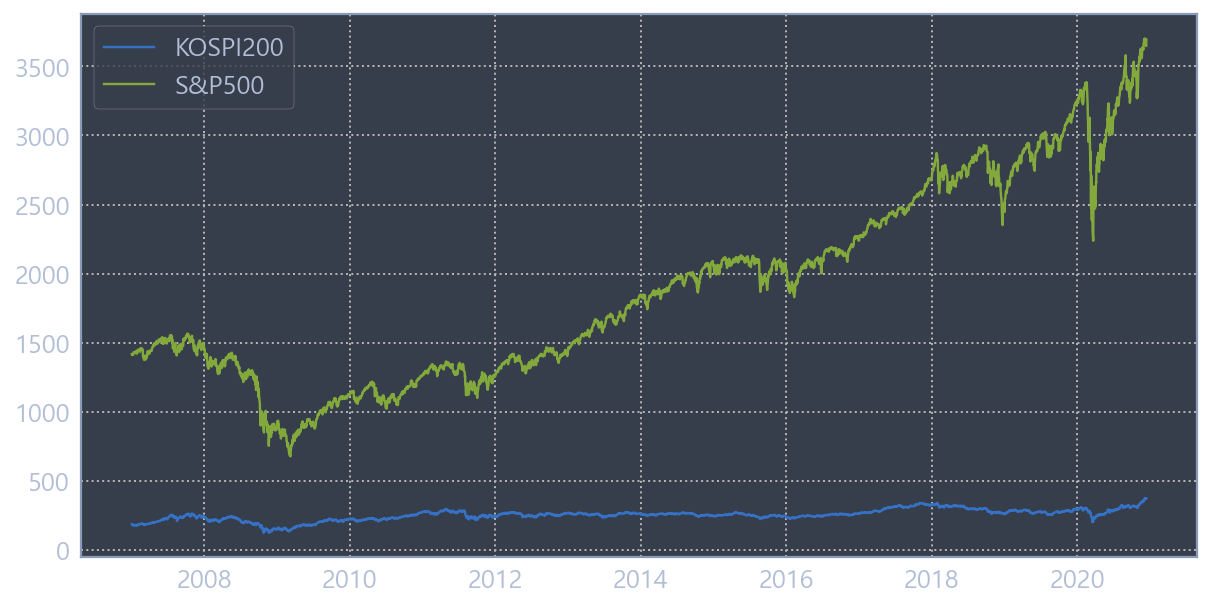

In [16]:
plt.figure(figsize=(10,5))
plt.plot(df_sort['KOSPI200'])
plt.plot(df_sort['S&P500'])
plt.legend(['KOSPI200','S&P500'],loc=0) # 범례 위치 지정
plt.grid(True, color='0.7', linestyle=':', linewidth=1) # 그리드 설정

#### 지수 활용
$$지수 = {{비교 시점 가격(지수) \over 기준 시점 가격(지수)}*100}$$

In [17]:
# 데이터프레임에서 특정 일자의 데이터를 뽑기
# 리스트와 유사 => iloc (index location)
df_sort.iloc[0]

KOSPI200     370.88
S&P500      3694.62
Name: 2020-12-15, dtype: float64

In [18]:
# 순서 대신 날짜로 지정 => loc (location)
df_sort.loc[dt.date(2008, 1, 2)]

KOSPI200     235.30
S&P500      1447.16
Name: 2008-01-02, dtype: float64

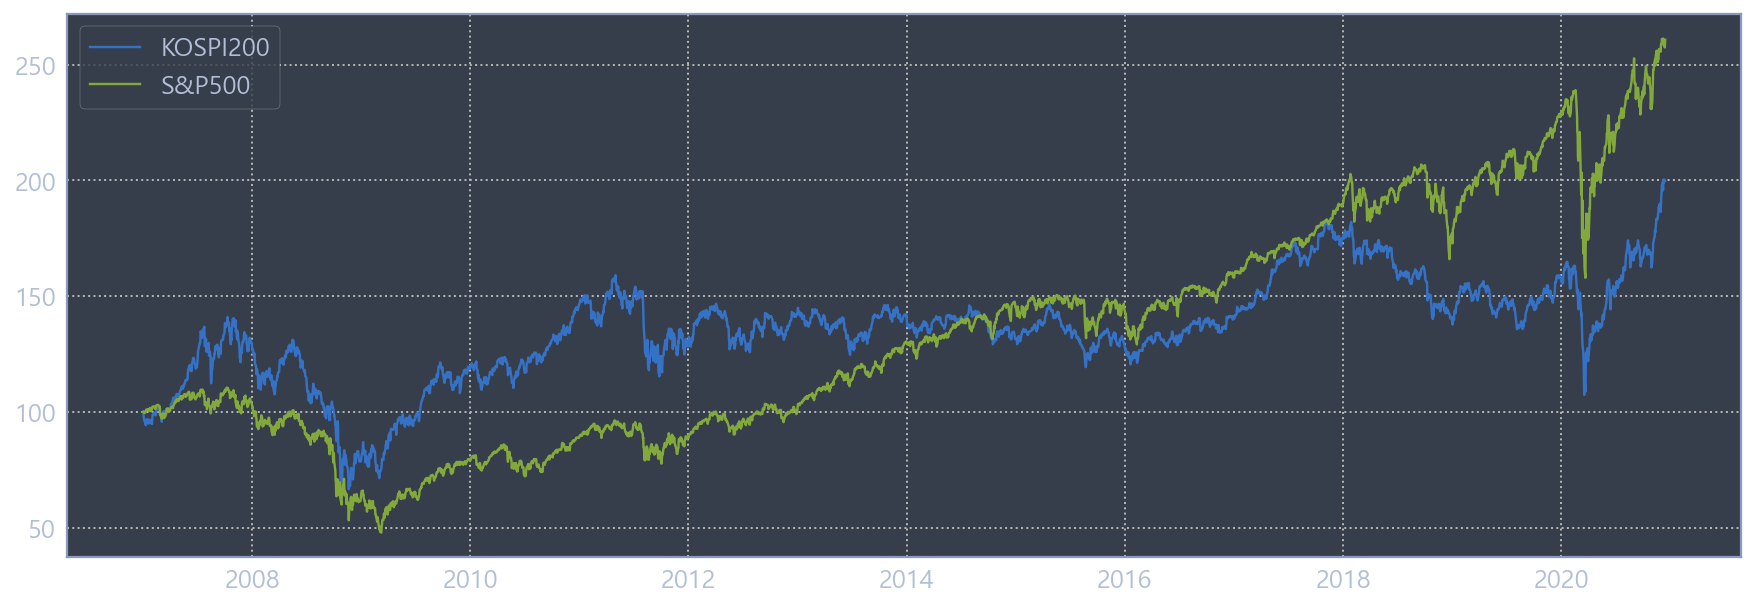

In [19]:
plt.figure(figsize=(15,5))
plt.plot(df_sort['KOSPI200'] / df_sort['KOSPI200'].loc[dt.date(2007, 1, 2)]*100)
plt.plot(df_sort['S&P500'] / df_sort['S&P500'].loc[dt.date(2007, 1, 2)]*100)
plt.legend(['KOSPI200','S&P500'],loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [20]:
# 2016년부터의 움직임
df_ratio_2016_now = df_sort.loc[:dt.date(2016, 1, 1)] / df_sort.loc[dt.date(2016, 1, 4)] * 100
df_ratio_2016_now.tail(3)

,KOSPI200,S&P500
2016-01-06,99.987214,98.887045
2016-01-05,100.639304,100.201226
2016-01-04,100.000000,100.000000


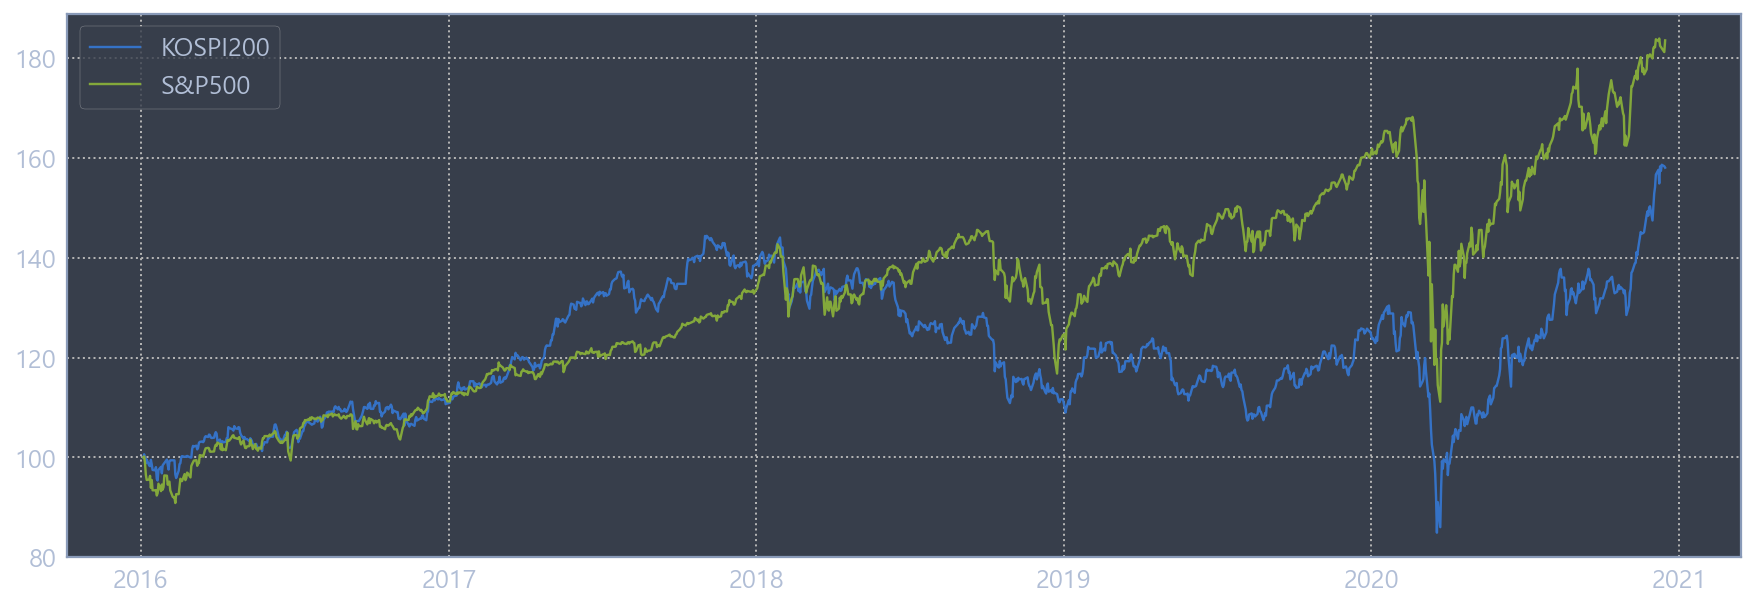

In [21]:
plt.figure(figsize=(15,5))
plt.plot(df_ratio_2016_now['KOSPI200'])
plt.plot(df_ratio_2016_now['S&P500'])
plt.legend(['KOSPI200','S&P500'],loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

----

#### 회귀분석
  + 두 지수의 상관관계 분석
  + sklearn.linear_model의 LinearRegression 사용
  + S&P500이 KOSPI200에 미치는 영향을 분석하고자 함
  + X(독립변수) = S&P500, Y(종속변수) = KOSPI200

Text(0, 0.5, 'KOSPI200')

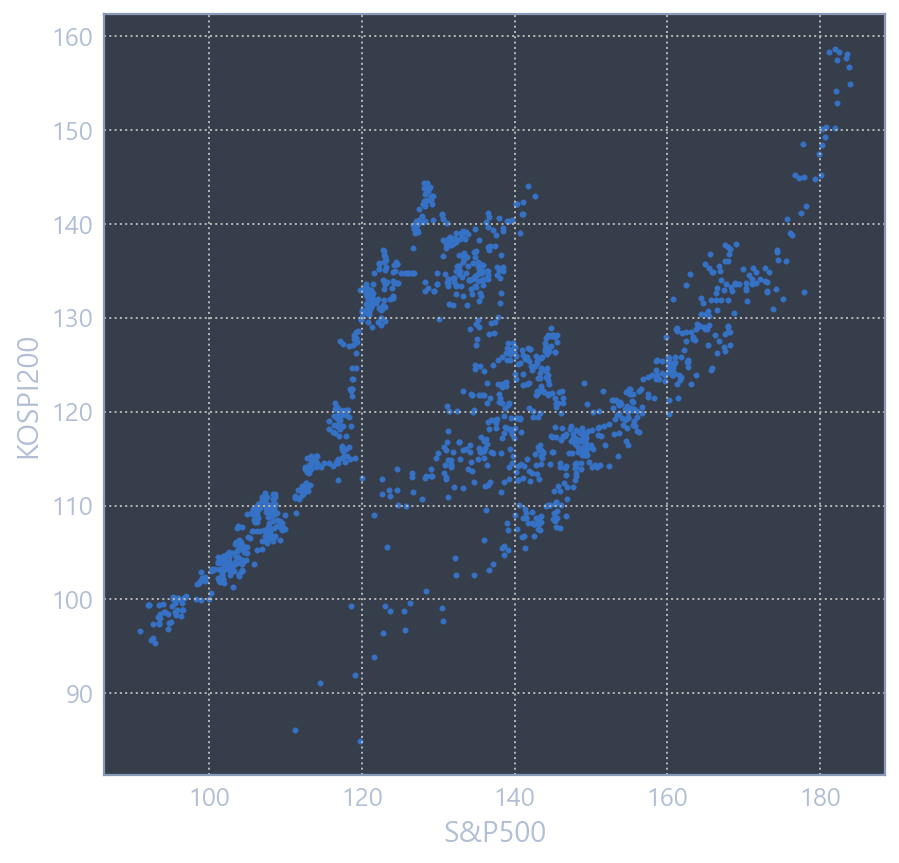

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(df_ratio_2016_now['S&P500'], df_ratio_2016_now['KOSPI200'], marker='.')
plt.grid(True, color='0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')

In [23]:
from sklearn.linear_model import LinearRegression

x = df_ratio_2016_now['S&P500']
y = df_ratio_2016_now['KOSPI200']

# 1개 칼럼 np.array로 변환
independent_var = np.array(x).reshape(-1,1)
dependent_var = np.array(y).reshape(-1,1)

# 회귀분석
regr = LinearRegression()
regr.fit(independent_var, dependent_var) # 회귀분석 시행

result = {'Slope': regr.coef_[0,0], 'Intercept': regr.intercept_[0], \
         'R^2': regr.score(independent_var, dependent_var)}
result

{'Slope': 0.3399433101336688,
 'Intercept': 75.66395902089052,
 'R^2': 0.31751573047169923}

Text(0, 0.5, 'KOSPI200')

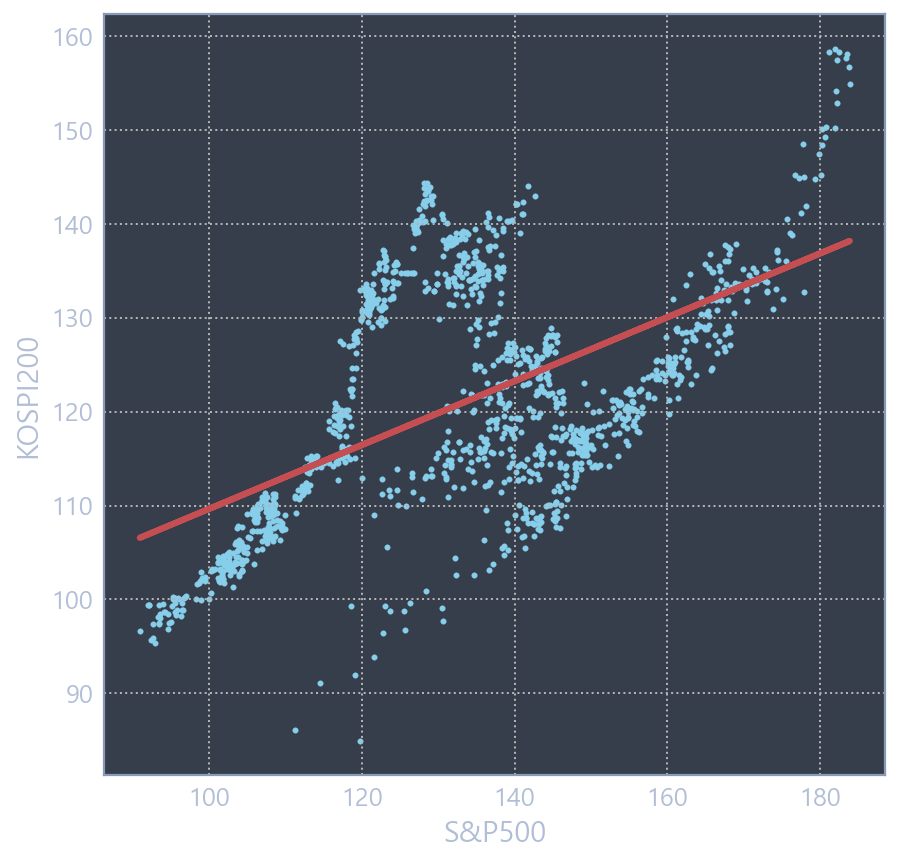

In [24]:
plt.figure(figsize=(7,7))
plt.scatter(independent_var, dependent_var, marker='.', color='skyblue')
plt.plot(independent_var, regr.predict(independent_var), color='r', linewidth=3)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')